# Case 2 - Clustering

### Import Modules

In [1]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score

### Load Data

In [2]:
data_path = '../data/HR_data.csv'
data_pd = pd.read_csv(data_path)

#Store column names
columns = data_pd.columns.tolist()

#print(data_pd.head())

#Print general parameters about the dataset
print(f"The dataset has {data_pd.shape[0]} rows and {data_pd.shape[1]} columns.")

print("Does the dataset have missing values?", data_pd.isnull().values.any())

The dataset has 312 rows and 68 columns.
Does the dataset have missing values? True


### Data handling

Impute missing values

In [ ]:
# Mode Imputation: Using SimpleImputer from scikit-learn to impute the missing values in the data (for categorical variables) with the most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
data_pd = categorical_imputer.fit_transform(data_pd)

# Converting the imputed data back to a DataFrame
data_pd = pd.DataFrame(data_pd, columns=columns)

Reorganize columns

In [4]:
# Move Unnamed: 0,Round,Phase,Individual,Puzzler,Cohort to the front of the DataFrame
data_pd = data_pd[['Unnamed: 0', 'Round', 'Phase', 'Individual', 'Puzzler', 'Cohort'] + [col for col in data_pd.columns if col not in ['Round', 'Phase', 'Individual', 'Puzzler', 'Cohort']]]

print(data_pd)

    Unnamed: 0    Round   Phase Individual Puzzler Cohort Unnamed: 0  \
0            0  round_3  phase3          1       1   D1_4          0   
1            1  round_3  phase2          1       1   D1_4          1   
2            2  round_3  phase1          1       1   D1_4          2   
3            3  round_2  phase3          1       1   D1_4          3   
4            4  round_2  phase2          1       1   D1_4          4   
..         ...      ...     ...        ...     ...    ...        ...   
307        307  round_4  phase2         26       1   D1_5        307   
308        308  round_4  phase1         26       1   D1_5        308   
309        309  round_1  phase3         26       1   D1_5        309   
310        310  round_1  phase2         26       1   D1_5        310   
311        311  round_1  phase1         26       1   D1_5        311   

     HR_TD_Mean HR_TD_Median  HR_TD_std  ... upset hostile alert ashamed  \
0     78.663878         76.7   7.480043  ...   1.0     1.0 

Extract and separate features

In [5]:
# Self-Rated Questionaire
self_rated = data_pd.iloc[:, -11:]

# Bio-Signals
bio_signals = data_pd.iloc[:, :-11]
# Only keep the columns that starts with 'HR', 'TEMP', or 'EDA'
bio_signals = bio_signals.loc[:, bio_signals.columns.str.startswith(('HR', 'TEMP', 'EDA'))]

# All features
X_all = pd.concat([self_rated, bio_signals], axis=1)

Normalization

In [6]:
# Normalizing the Bio-Signals using StandardScaler
scaler = StandardScaler()
bio_signals_scaled = scaler.fit_transform(bio_signals)

# Normalizing the Self-Rated Questionnaire using StandardScaler
self_rated_scaled = scaler.fit_transform(self_rated)

# Normalizing the all features using StandardScaler
X_all_scaled = scaler.fit_transform(X_all)

Correlation Matrix

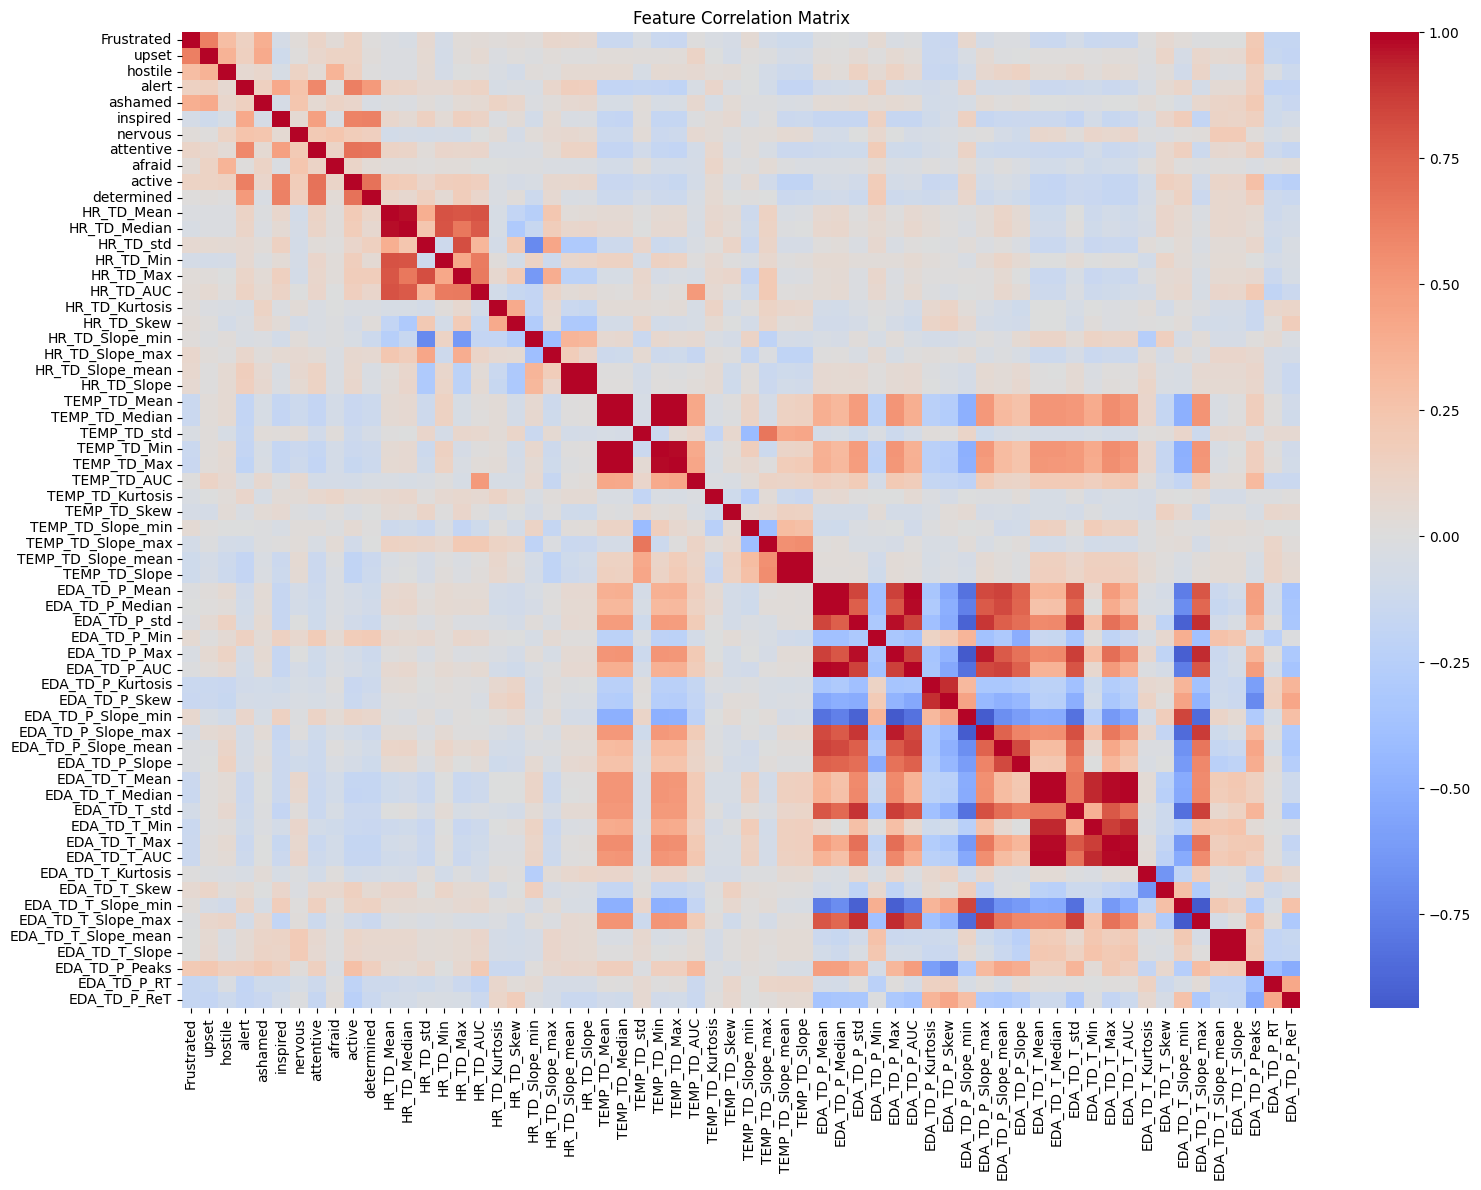

In [7]:
# Feature correlation analysis
plt.figure(figsize=(16, 12))
correlation_matrix = X_all.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('feature_correlation.png')
plt.show()

## Clustering Methods

### Apply PCA

In [8]:
def apply_pca(X, n_components=10):
    """Apply PCA to reduce dimensionality while preserving variance"""
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # Explained variance analysis
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(explained_variance) + 1), explained_variance)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Variance Explained by Each Principal Component')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('pca_variance.png')
    plt.show()
    
    # Number of components needed for 80% variance
    n_for_80pct = np.argmax(cumulative_variance >= 0.8) + 1
    print(f"Number of components needed for 80% variance: {n_for_80pct}")
    
    return X_pca, pca


--- PCA ---


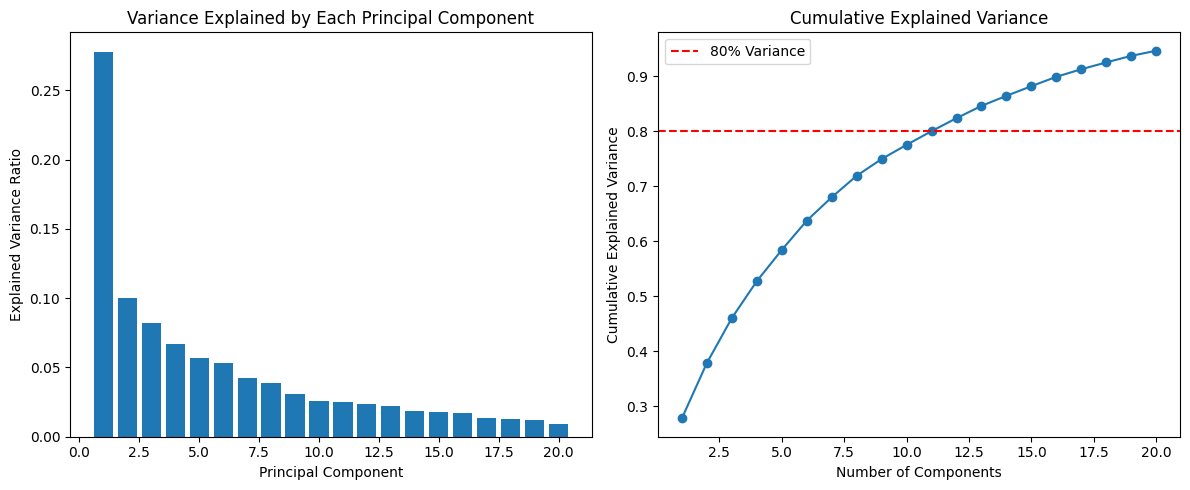

Number of components needed for 80% variance: 11


In [9]:
print("\n--- PCA ---")
bio_signals_pca, pca_model = apply_pca(bio_signals_scaled, n_components=min(20, bio_signals_scaled.shape[1], bio_signals_scaled.shape[0]))

### K-means Clustering

In [10]:
def apply_kmeans_clustering(X, target_clusters=10, max_clusters=15):
    """
    Apply K-means clustering focused around target number of clusters
    """
    # Evaluate a range of clusters around the target
    min_k = max(2, target_clusters - 5)
    max_k = min(max_clusters, target_clusters + 5)
    k_range = range(min_k, max_k + 1)
    
    inertias = []
    silhouette_scores = []
    ch_scores = []  # Calinski-Harabasz scores
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        inertias.append(kmeans.inertia_)
        
        if k > 1:  # Silhouette score requires at least 2 clusters
            sil_score = silhouette_score(X, labels)
            silhouette_scores.append(sil_score)
            ch_score = calinski_harabasz_score(X, labels)
            ch_scores.append(ch_score)
        else:
            silhouette_scores.append(0)
            ch_scores.append(0)
    
    # Create plot with 3 metrics
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.plot(k_range, inertias, 'o-', color='blue')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(k_range, silhouette_scores, 'o-', color='green')
    plt.title('Silhouette Scores')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(k_range, ch_scores, 'o-', color='purple')
    plt.title('Calinski-Harabasz Index')
    plt.xlabel('Number of clusters')
    plt.ylabel('CH Score')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('kmeans_metrics.png')
    plt.show()
    
    # Determine optimal k, prioritizing the target if scores are similar
    optimal_k_sil = k_range[silhouette_scores.index(max(silhouette_scores))]
    
    # If target is close to optimal in performance, prefer the target
    target_sil_score = silhouette_scores[k_range.index(target_clusters)] if target_clusters in k_range else 0
    max_sil_score = max(silhouette_scores)
    
    # If target cluster silhouette score is within 95% of the max, use target
    if target_sil_score >= 0.95 * max_sil_score:
        optimal_k = target_clusters
    else:
        optimal_k = optimal_k_sil
    
    print(f"Optimal number of clusters based on silhouette score: {optimal_k_sil}")
    print(f"Selected number of clusters: {optimal_k}")
    
    # Apply K-means with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    return labels, kmeans.cluster_centers_, optimal_k

### GMM Clustering

In [11]:
def apply_gmm_clustering(X, target_components=10, max_components=15):
    """
    Apply Gaussian Mixture Model clustering focusing on target number of components
    """
    # Evaluate a range around the target
    min_comp = max(2, target_components - 5)
    max_comp = min(max_components, target_components + 5)
    n_components_range = range(min_comp, max_comp + 1)
    
    bic_scores = []
    aic_scores = []
    silhouette_scores = []
    
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, random_state=42, covariance_type='full')
        gmm.fit(X)
        labels = gmm.predict(X)
        bic_scores.append(gmm.bic(X))
        aic_scores.append(gmm.aic(X))
        
        if n_components > 1:  # Silhouette score requires at least 2 clusters
            sil_score = silhouette_score(X, labels)
            silhouette_scores.append(sil_score)
        else:
            silhouette_scores.append(0)
    
    # Plot BIC and AIC scores
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.plot(n_components_range, bic_scores, 'o-', color='blue')
    plt.title('BIC Scores')
    plt.xlabel('Number of components')
    plt.ylabel('BIC Score')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(n_components_range, aic_scores, 'o-', color='green')
    plt.title('AIC Scores')
    plt.xlabel('Number of components')
    plt.ylabel('AIC Score')
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(n_components_range, silhouette_scores, 'o-', color='purple')
    plt.title('Silhouette Scores')
    plt.xlabel('Number of components')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('gmm_metrics.png')
    plt.show()
    
    # Choose optimal components based on scores
    optimal_comp_bic = n_components_range[bic_scores.index(min(bic_scores))]
    
    # If target is close to optimal in performance, prefer the target
    target_bic = bic_scores[n_components_range.index(target_components)] if target_components in n_components_range else float('inf')
    min_bic = min(bic_scores)
    
    # If target component BIC is within 5% of the minimum, use target
    if target_bic <= 1.05 * min_bic:
        optimal_components = target_components
    else:
        optimal_components = optimal_comp_bic
    
    print(f"Optimal number of GMM components based on BIC: {optimal_comp_bic}")
    print(f"Selected number of components: {optimal_components}")
    
    # Apply GMM with selected number of components
    gmm = GaussianMixture(n_components=optimal_components, random_state=42, covariance_type='full')
    labels = gmm.fit_predict(X)
    
    return labels, gmm.means_, optimal_components

### Plotting functions

2D Plots using PCA

In [12]:
def visualize_clusters_2d(X, labels, centers=None, method_name="", pca_model=None):
    """
    Visualize clusters in 2D using PCA
    """
    # Create a figure with two subplots
    plt.figure(figsize=(20, 10))
    
    # Get unique cluster labels
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)
    colors = cm.viridis(np.linspace(0, 1, n_clusters))
    
    # PCA plot - first two components
    plt.subplot(1, 2, 1)
    for i, label in enumerate(unique_labels):
        cluster_points = X[labels == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    color=colors[i], alpha=0.7, label=f'Cluster {label}')
    
    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], c='red', s=150, marker='X', 
                   edgecolors='black', linewidths=1.5, label='Centroids')
    
    plt.title(f'PCA Visualization of {method_name} Clusters (PC1 vs PC2)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # If we have enough components, add a PC3 vs PC2 plot
    if X.shape[1] >= 3:
        plt.subplot(1, 2, 2)
        for i, label in enumerate(unique_labels):
            cluster_points = X[labels == label]
            plt.scatter(cluster_points[:, 1], cluster_points[:, 2], 
                        color=colors[i], alpha=0.7)
        
        if centers is not None:
            plt.scatter(centers[:, 1], centers[:, 2], c='red', s=150, marker='X', 
                       edgecolors='black', linewidths=1.5)
        
        plt.title(f'PCA Visualization of {method_name} Clusters (PC2 vs PC3)')
        plt.xlabel('Principal Component 2')
        plt.ylabel('Principal Component 3')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{method_name.lower()}_clusters_2d.png')
    plt.show()
    
    # Feature importance for top principal components
    if pca_model is not None:
        n_features = min(10, len(pca_model.components_[0]))
        plt.figure(figsize=(16, 12))
        
        for i in range(min(3, len(pca_model.components_))):
            plt.subplot(3, 1, i+1)
            
            # Get the feature importance from PCA
            feature_importance = np.abs(pca_model.components_[i])
            feature_names = X_all.columns
            
            # Sort feature importance
            indices = np.argsort(feature_importance)[::-1][:n_features]
            
            plt.barh(range(n_features), feature_importance[indices], align='center')
            plt.yticks(range(n_features), [feature_names[j] for j in indices])
            plt.title(f'Top Features in Principal Component {i+1}')
            plt.xlabel('Absolute Weight')
        
        plt.tight_layout()
        plt.savefig(f'{method_name.lower()}_feature_importance.png')
        plt.show()

Other plots

In [13]:
def analyze_clusters(X_original, labels, method_name=""):
    """
    Analyze the characteristics of each cluster
    """
    # Ensure X_original is a DataFrame with numeric values only
    if isinstance(X_original, pd.DataFrame):
        # Make a copy to avoid modifying the original
        data_for_analysis = X_original.copy()
        
        # Check if there are any non-numeric columns and handle them
        for col in data_for_analysis.columns:
            if not pd.api.types.is_numeric_dtype(data_for_analysis[col]):
                print(f"Warning: Column '{col}' is not numeric. Converting to numeric or dropping.")
                try:
                    # Try to convert to numeric
                    data_for_analysis[col] = pd.to_numeric(data_for_analysis[col], errors='coerce')
                except:
                    # If conversion fails, drop the column
                    data_for_analysis = data_for_analysis.drop(columns=[col])
                    print(f"Column '{col}' dropped from analysis.")
    else:
        # If not a DataFrame, try to convert it
        try:
            data_for_analysis = pd.DataFrame(X_original)
        except:
            raise TypeError("X_original must be convertible to a pandas DataFrame with numeric values")
    
    # Add the cluster labels to the analysis data
    data_with_clusters = data_for_analysis.copy()
    data_with_clusters['Cluster'] = labels
    
    # Compute cluster statistics
    cluster_stats = data_with_clusters.groupby('Cluster').mean()
    
    # Check for NaN or inf values in cluster_stats before normalization
    if cluster_stats.isna().any().any() or np.isinf(cluster_stats.values).any():
        print("Warning: NaN or infinite values found in cluster statistics. Filling with zeros.")
        cluster_stats = cluster_stats.fillna(0).replace([np.inf, -np.inf], 0)
    
    # Safe normalization that handles zeros in denominators
    try:
        # First handle the case where min and max are the same
        denom = cluster_stats.max() - cluster_stats.min()
        # Replace zeros in denominator with 1 to avoid division by zero
        denom = denom.replace(0, 1)
        cluster_stats_norm = (cluster_stats - cluster_stats.min()) / denom
    except Exception as e:
        print(f"Error during normalization: {e}")
        print("Using non-normalized data for visualization")
        cluster_stats_norm = cluster_stats
    
    # Plot heatmap of cluster characteristics
    try:
        plt.figure(figsize=(18, 12))
        sns.heatmap(cluster_stats_norm, annot=False, cmap='coolwarm', center=0.5)
        plt.title(f'Feature Means for {method_name} Clusters')
        plt.tight_layout()
        plt.savefig(f'{method_name.lower()}_cluster_heatmap.png')
        plt.show()
    except Exception as e:
        print(f"Error creating heatmap: {e}")
        print("Skipping heatmap visualization.")
    
    # Most distinctive features for each cluster
    distinctive_features = pd.DataFrame()
    
    try:
        # Calculate overall means for comparison
        overall_means = data_for_analysis.mean()
        
        for cluster_id in sorted(np.unique(labels)):
            # Calculate how much each feature in this cluster deviates from overall mean
            if cluster_id in cluster_stats.index:
                deviation = cluster_stats.loc[cluster_id] - overall_means
                
                # Sort features by absolute deviation
                sorted_features = deviation.abs().sort_values(ascending=False)
                
                # Get top 5 most distinctive features for this cluster
                top_n = min(5, len(sorted_features))
                top_features = sorted_features.head(top_n).index.tolist()
                distinctive_features[f'Cluster {cluster_id}'] = top_features + [''] * (5 - top_n)  # Pad with empty strings if needed
    except Exception as e:
        print(f"Error identifying distinctive features: {e}")
        distinctive_features = pd.DataFrame({f'Cluster {i}': ['Error calculating features'] for i in range(len(np.unique(labels)))})
    
    print(f"\n{method_name} - Most distinctive features for each cluster:")
    print(distinctive_features)
    
    return cluster_stats, distinctive_features

## Results

### K-means Clustering


--- K-means Clustering ---


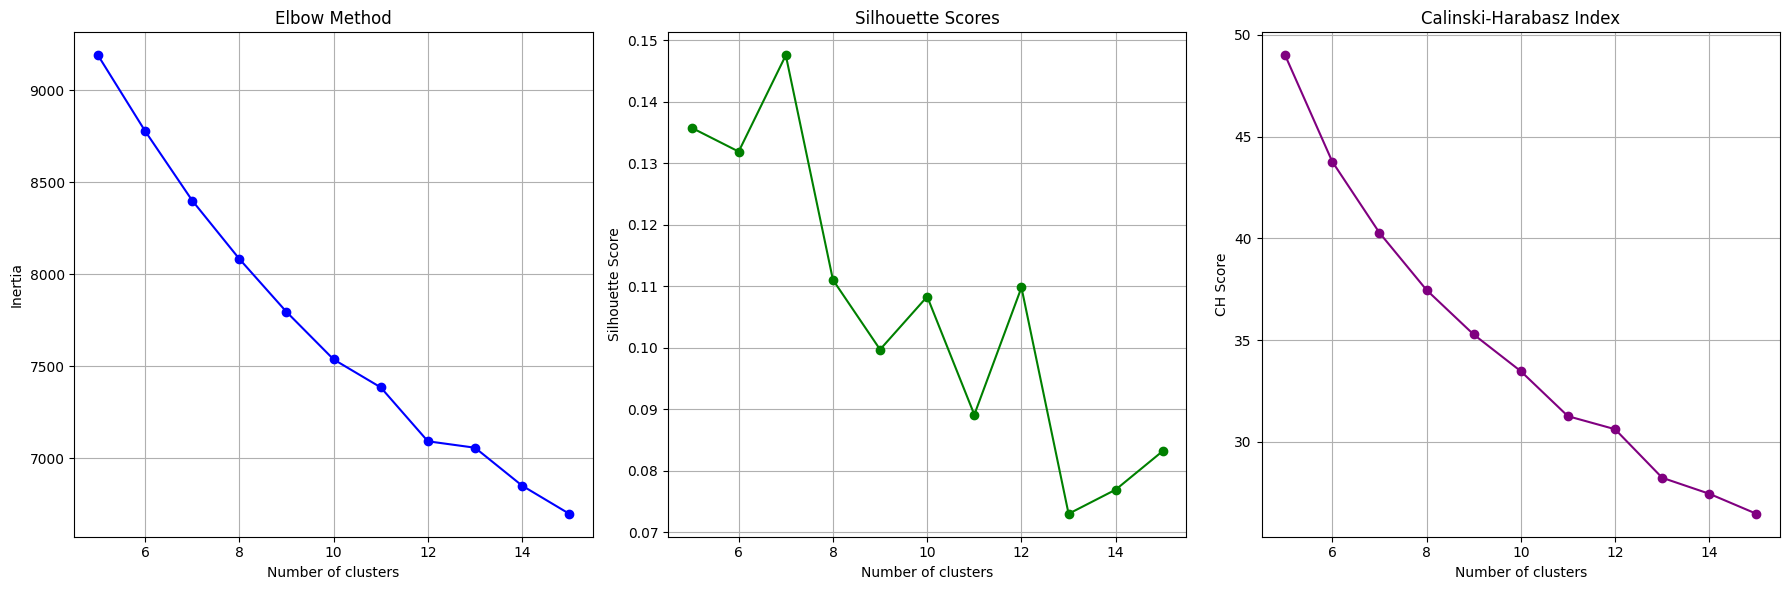

Optimal number of clusters based on silhouette score: 7
Selected number of clusters: 7


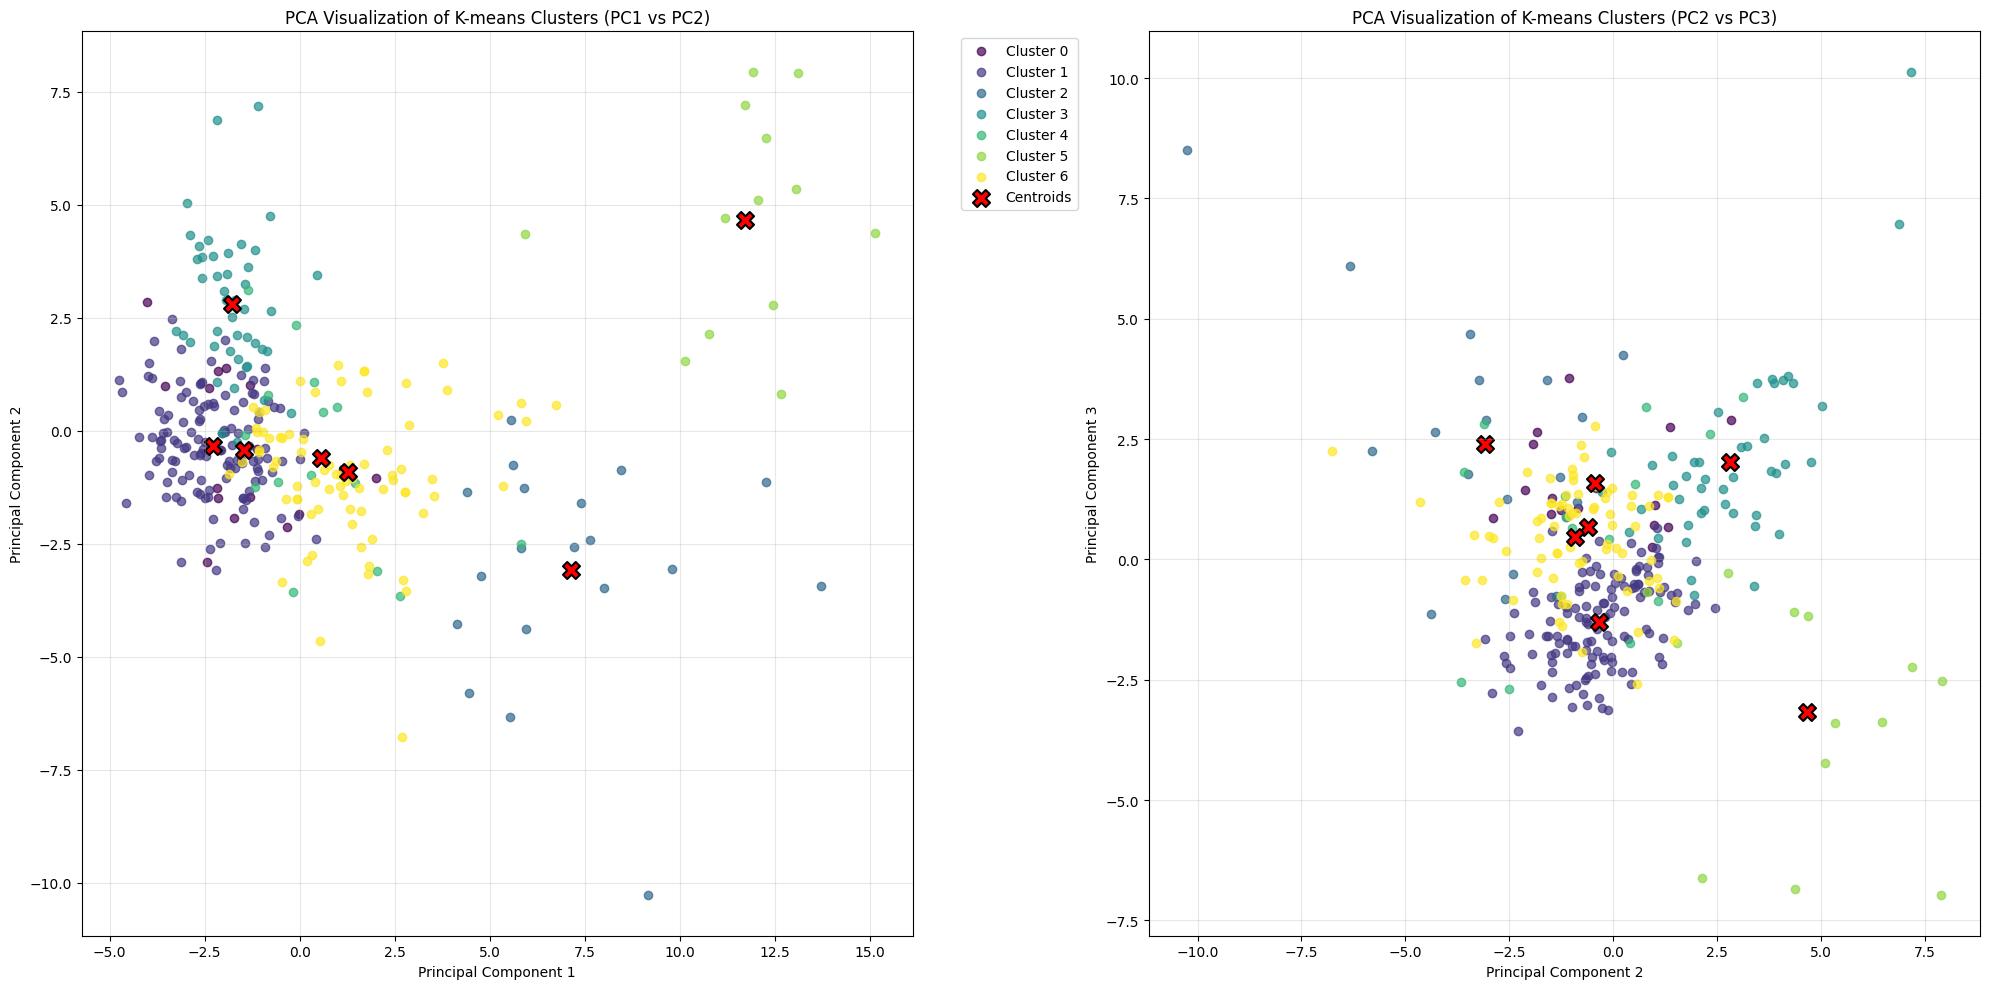

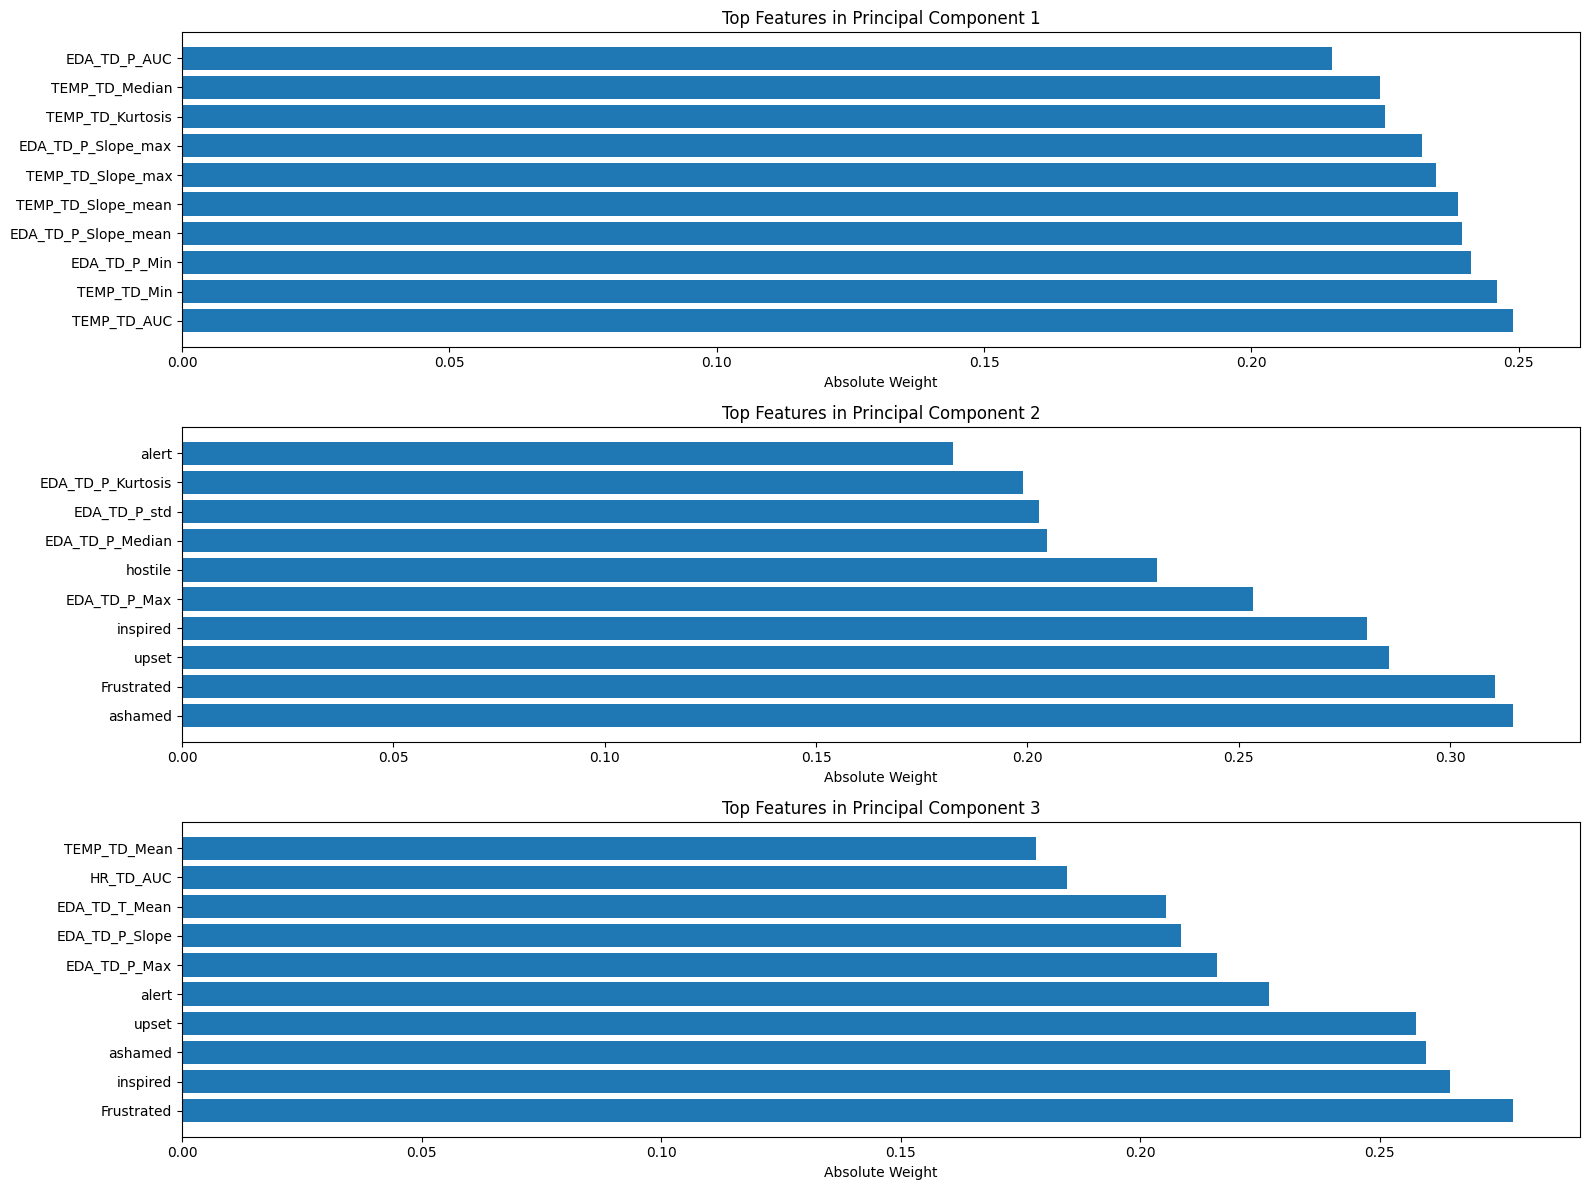

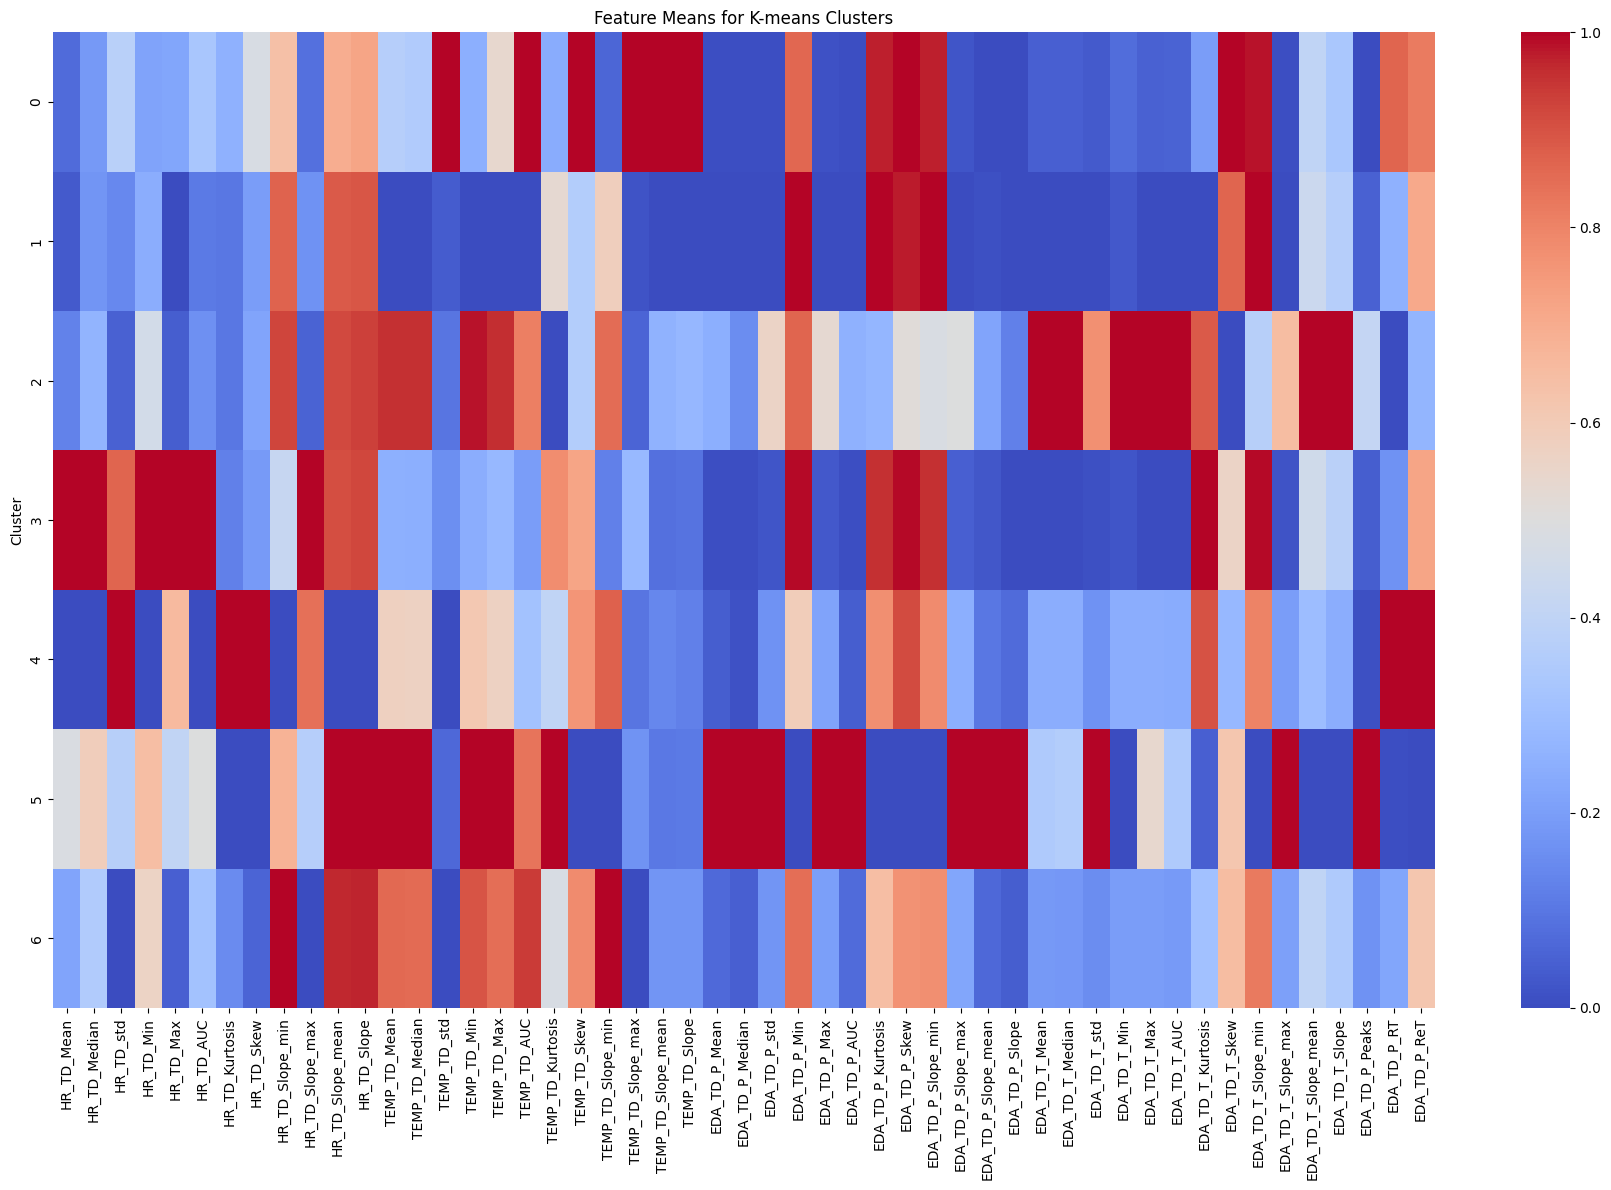


K-means - Most distinctive features for each cluster:
      Cluster 0     Cluster 1     Cluster 2     Cluster 3     Cluster 4  \
0   TEMP_TD_AUC  EDA_TD_T_AUC  EDA_TD_T_AUC     HR_TD_AUC     HR_TD_AUC   
1  EDA_TD_T_AUC   TEMP_TD_AUC   TEMP_TD_AUC  EDA_TD_T_AUC  EDA_TD_T_AUC   
2  EDA_TD_P_AUC     HR_TD_AUC     HR_TD_AUC   TEMP_TD_AUC   TEMP_TD_AUC   
3     HR_TD_AUC  EDA_TD_P_AUC  EDA_TD_P_AUC  EDA_TD_P_AUC  EDA_TD_P_AUC   
4  HR_TD_Median     HR_TD_Max  EDA_TD_T_Max     HR_TD_Max     HR_TD_Max   

        Cluster 5          Cluster 6  
0    EDA_TD_P_AUC        TEMP_TD_AUC  
1    EDA_TD_T_AUC       EDA_TD_T_AUC  
2     TEMP_TD_AUC       EDA_TD_P_AUC  
3       HR_TD_AUC          HR_TD_Max  
4  EDA_TD_P_Peaks  EDA_TD_P_Kurtosis  


In [14]:
print("\n--- K-means Clustering ---")
kmeans_labels, kmeans_centers_pca, optimal_k = apply_kmeans_clustering(bio_signals_pca, target_clusters=10)

# Visualize K-means clusters in PCA space
visualize_clusters_2d(bio_signals_pca, kmeans_labels, centers=kmeans_centers_pca, method_name="K-means", pca_model=pca_model)

# Transform centers back to original feature space for interpretation (if needed)
kmeans_centers_original = pca_model.inverse_transform(kmeans_centers_pca)

# Analyze K-means clusters
kmeans_stats, kmeans_distinctive = analyze_clusters(bio_signals, kmeans_labels, method_name="K-means")

### GMM Clustering


--- Gaussian Mixture Model Clustering ---


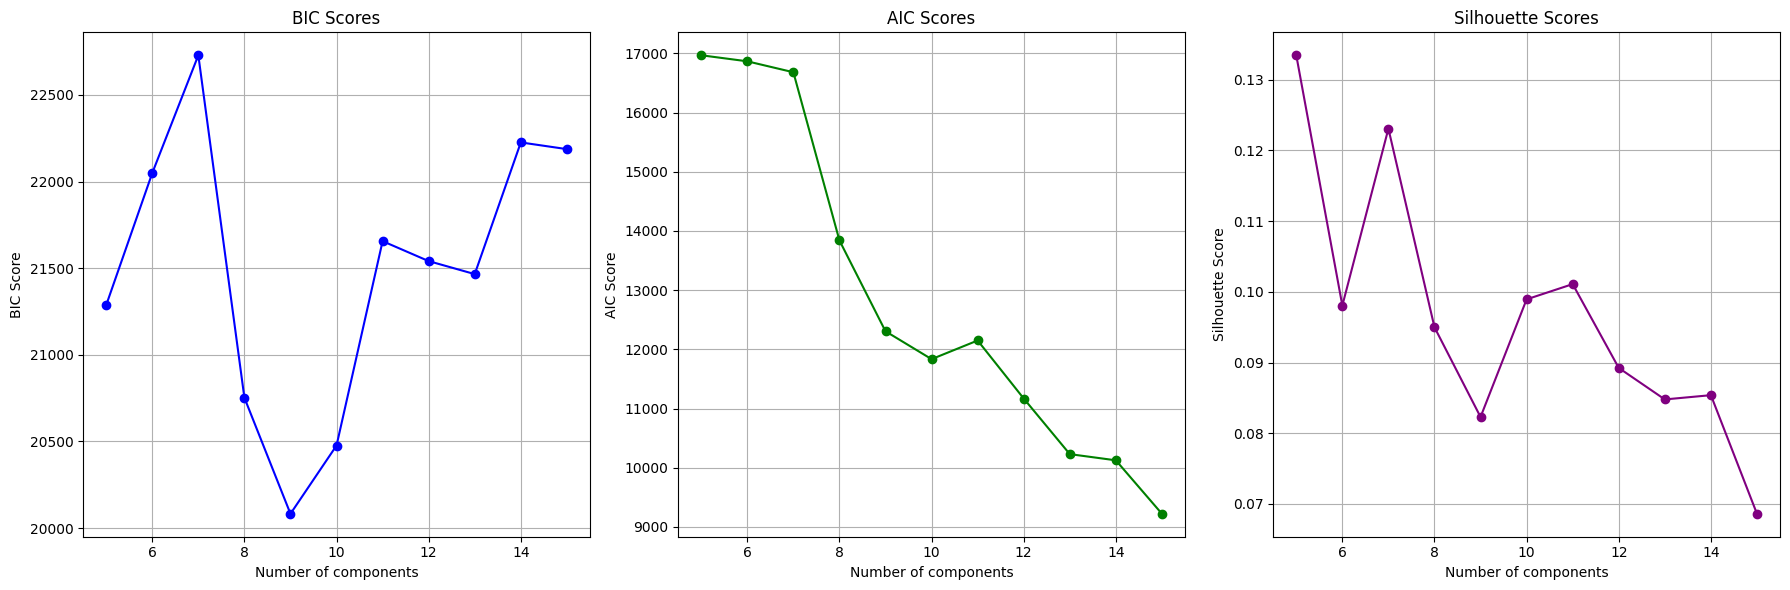

Optimal number of GMM components based on BIC: 9
Selected number of components: 10


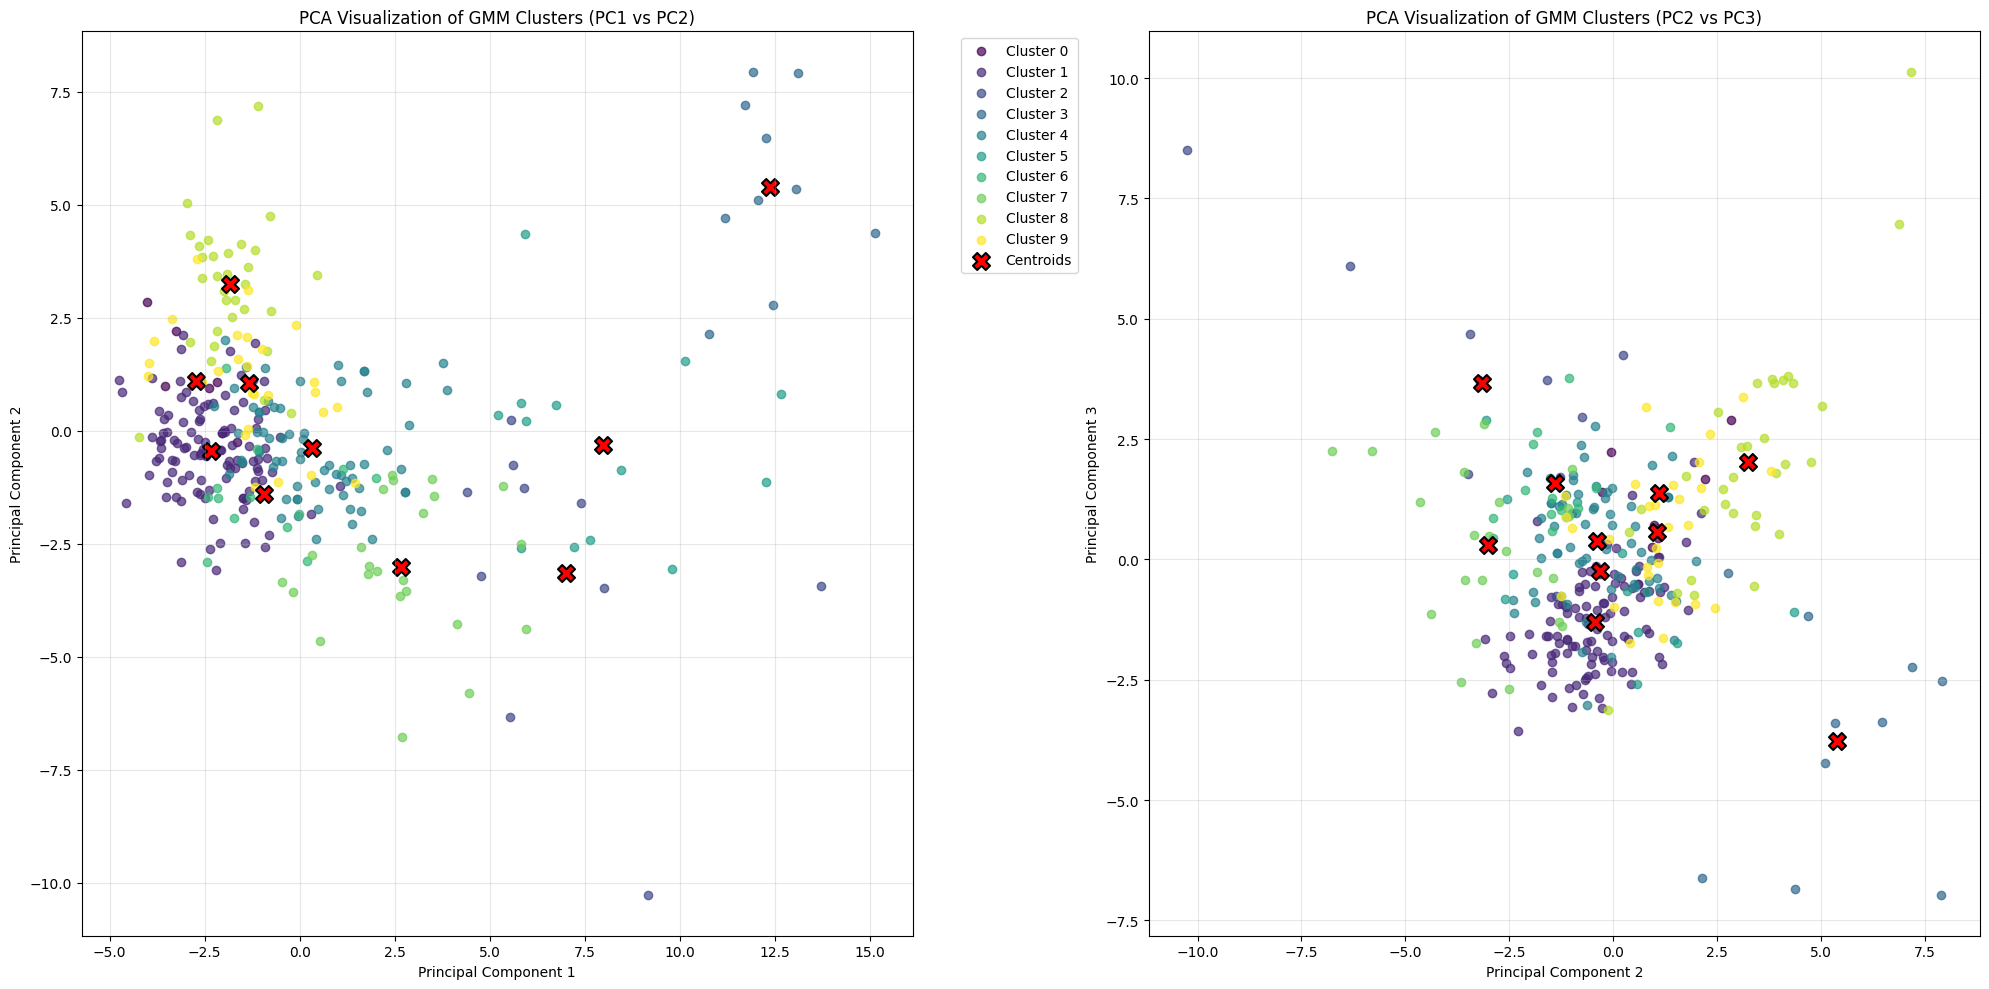

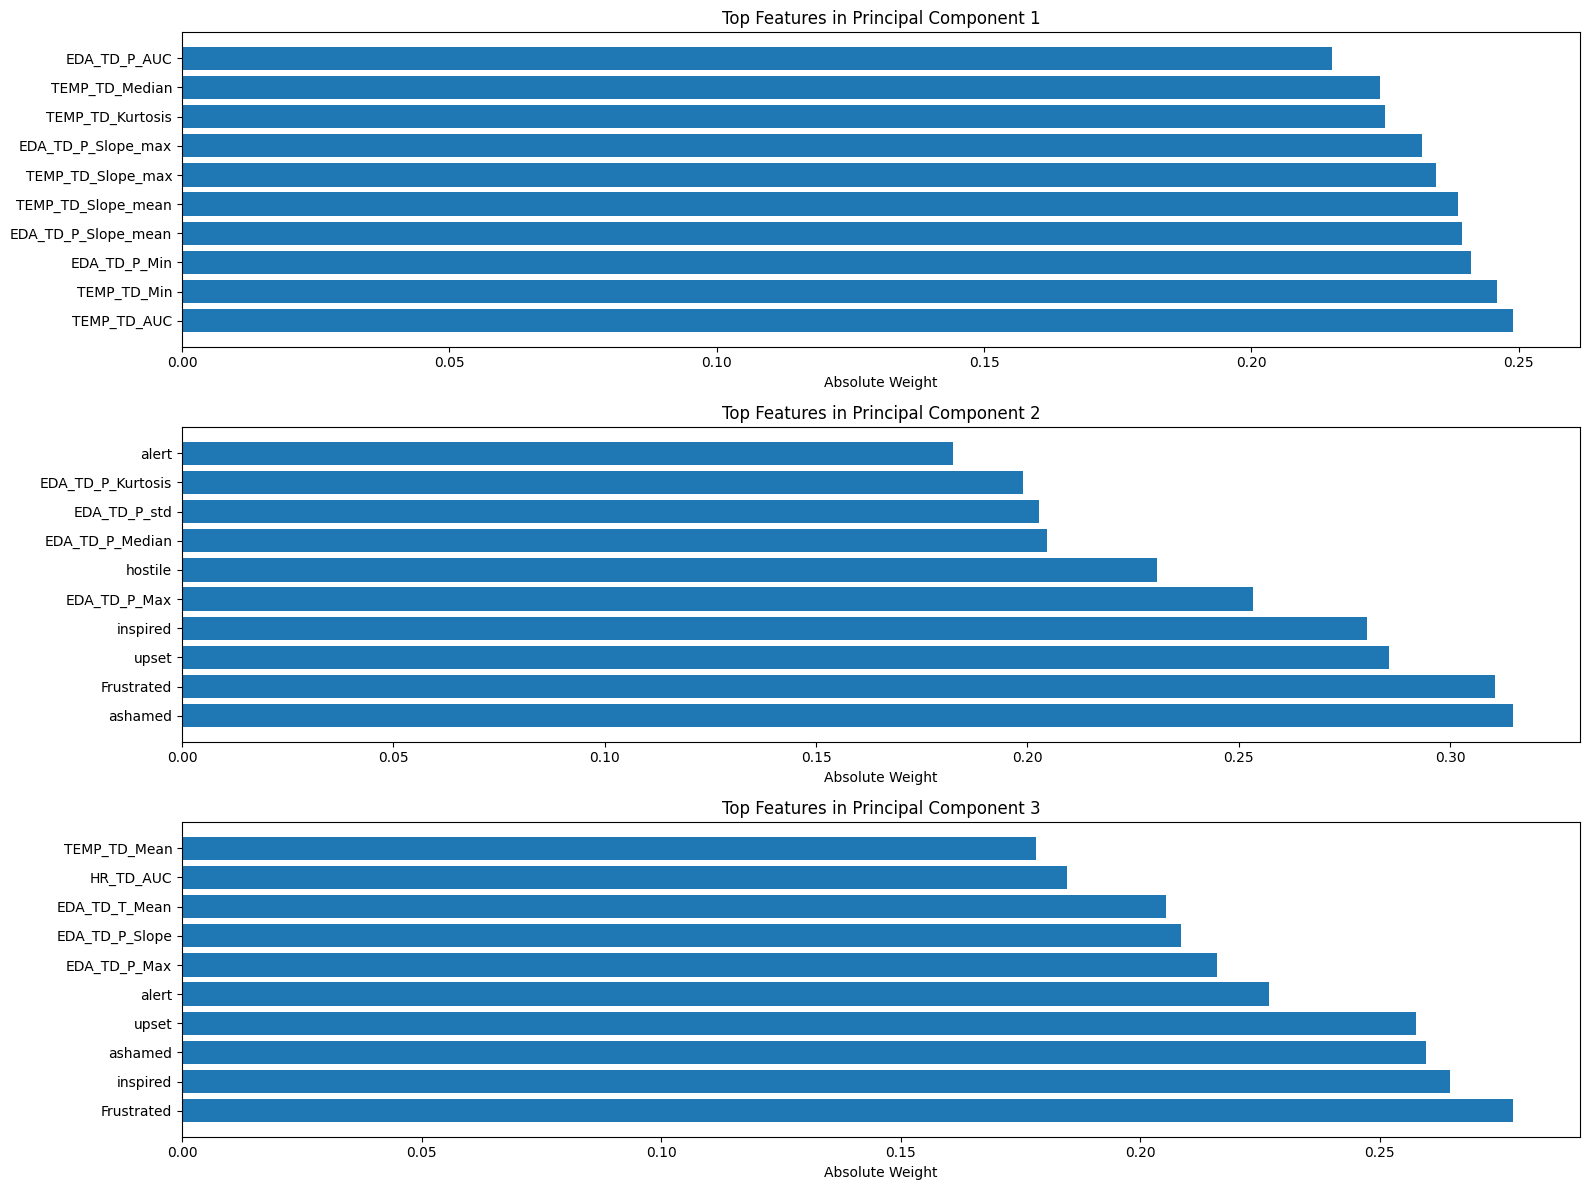

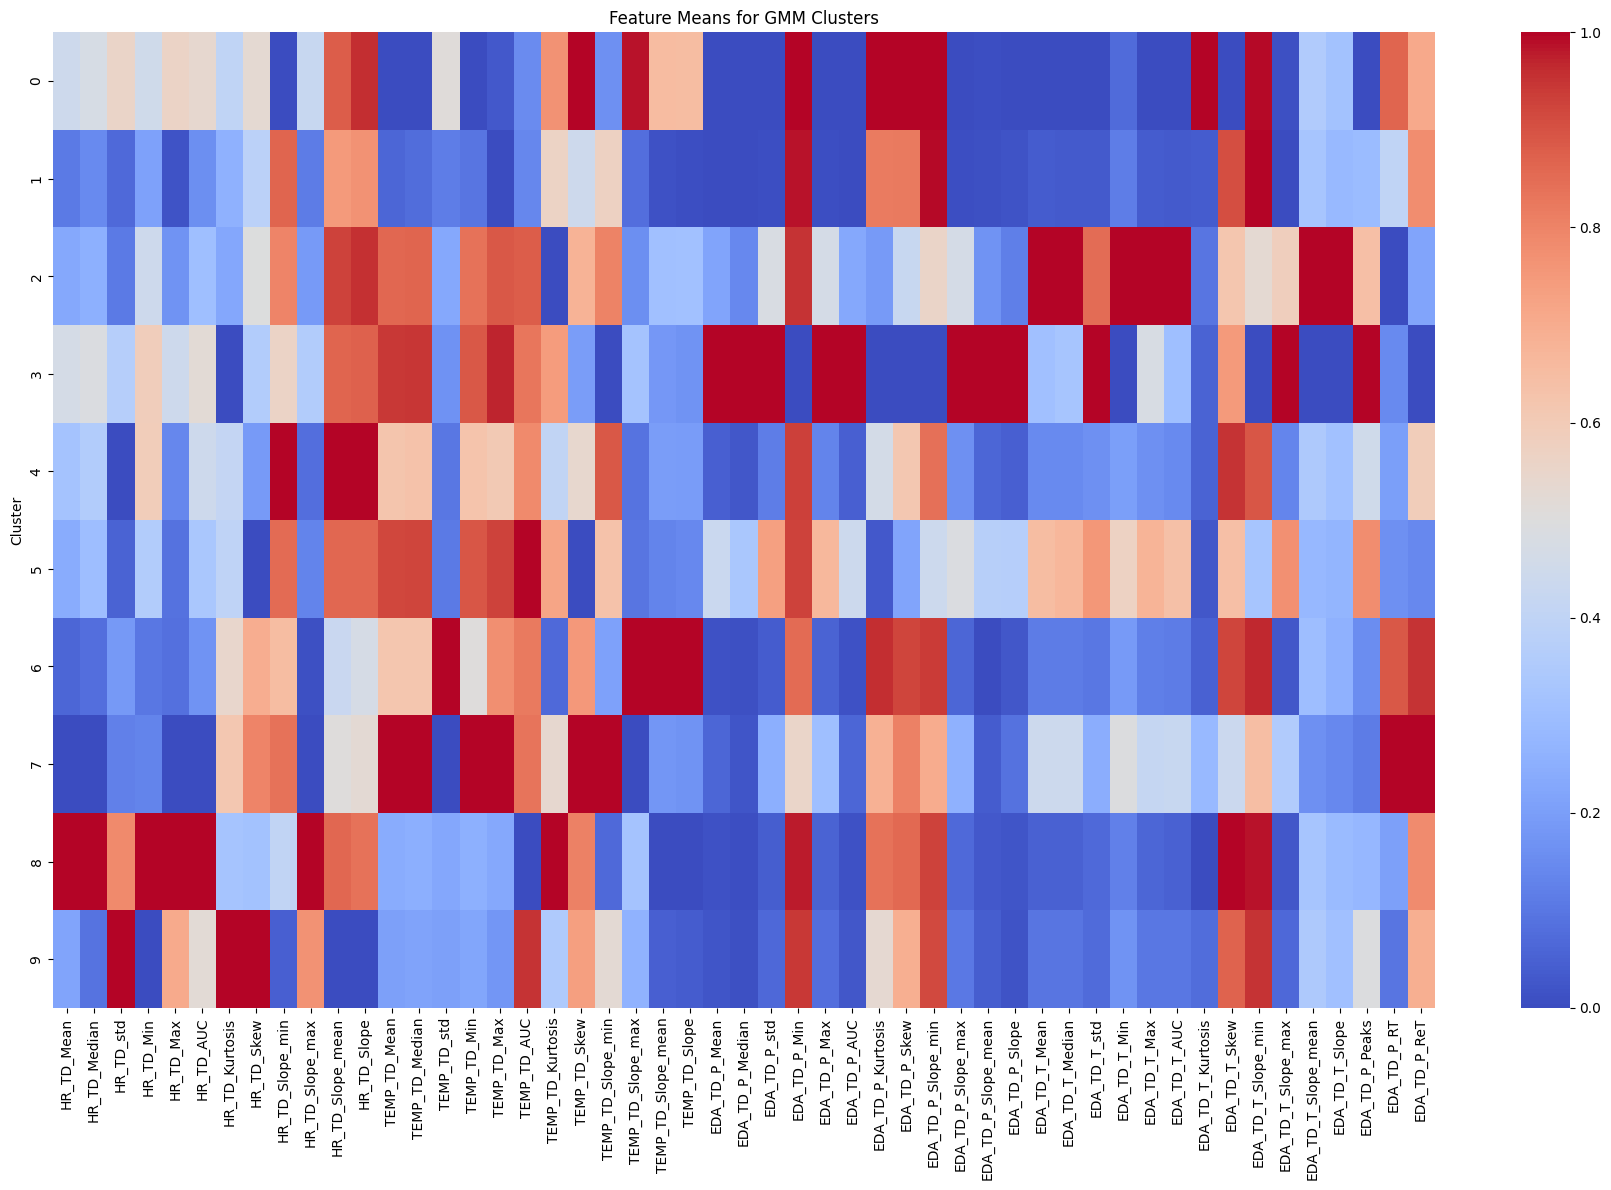


GMM - Most distinctive features for each cluster:
        Cluster 0     Cluster 1     Cluster 2       Cluster 3     Cluster 4  \
0    EDA_TD_T_AUC  EDA_TD_T_AUC  EDA_TD_T_AUC    EDA_TD_P_AUC   TEMP_TD_AUC   
1     TEMP_TD_AUC   TEMP_TD_AUC   TEMP_TD_AUC    EDA_TD_T_AUC     HR_TD_AUC   
2       HR_TD_AUC     HR_TD_AUC  EDA_TD_P_AUC     TEMP_TD_AUC  EDA_TD_T_AUC   
3    EDA_TD_P_AUC  EDA_TD_P_AUC     HR_TD_AUC       HR_TD_AUC  EDA_TD_P_AUC   
4  EDA_TD_P_Peaks     HR_TD_Max  EDA_TD_T_Max  EDA_TD_P_Peaks     HR_TD_Max   

        Cluster 5       Cluster 6     Cluster 7     Cluster 8     Cluster 9  
0    EDA_TD_T_AUC       HR_TD_AUC  EDA_TD_T_AUC     HR_TD_AUC   TEMP_TD_AUC  
1     TEMP_TD_AUC     TEMP_TD_AUC     HR_TD_AUC  EDA_TD_T_AUC  EDA_TD_T_AUC  
2    EDA_TD_P_AUC    EDA_TD_T_AUC   TEMP_TD_AUC   TEMP_TD_AUC     HR_TD_AUC  
3       HR_TD_AUC    EDA_TD_P_AUC  EDA_TD_P_AUC  EDA_TD_P_AUC  EDA_TD_P_AUC  
4  EDA_TD_P_Peaks  EDA_TD_P_Peaks     HR_TD_Max     HR_TD_Max     HR_TD_Max  


In [15]:
print("\n--- Gaussian Mixture Model Clustering ---")
gmm_labels, gmm_centers_pca, optimal_components = apply_gmm_clustering(bio_signals_pca, target_components=10)

# Visualize GMM clusters in PCA space
visualize_clusters_2d(bio_signals_pca, gmm_labels, centers=gmm_centers_pca, method_name="GMM", pca_model=pca_model)

# Transform centers back to original feature space
gmm_centers_original = pca_model.inverse_transform(gmm_centers_pca)

# Analyze GMM clusters
gmm_stats, gmm_distinctive = analyze_clusters(bio_signals, gmm_labels, method_name="GMM")

### Comparing K-Means and GMM

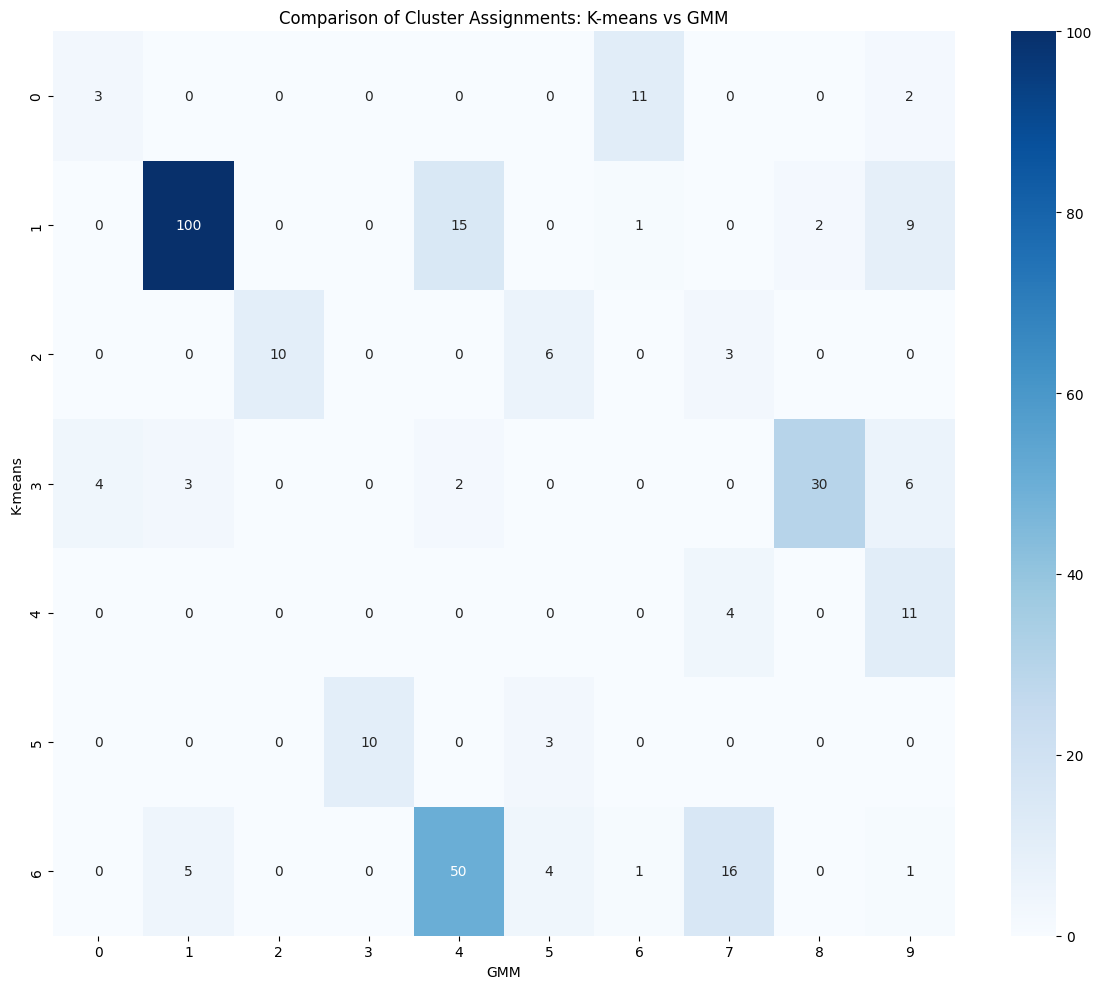

In [16]:
try:
    plt.figure(figsize=(12, 10))
    confusion_matrix = pd.crosstab(pd.Series(kmeans_labels, name='K-means'),
                                  pd.Series(gmm_labels, name='GMM'))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
    plt.title('Comparison of Cluster Assignments: K-means vs GMM')
    plt.tight_layout()
    plt.savefig('cluster_comparison.png')
    plt.show()
except Exception as e:
    print(f"Error creating cluster comparison: {e}")
    print("Skipping cluster comparison visualization.")


### Emotion Labels

In [17]:
print("\n--- Suggested Emotion Labels Based on Feature Patterns ---")
for method, stats, distinctive in [("K-means", kmeans_stats, kmeans_distinctive), 
                                  ("GMM", gmm_stats, gmm_distinctive)]:
    print(f"\n{method} Clusters:")
    for cluster in range(len(stats)):
        print(f"Cluster {cluster} - Potential emotion label could be determined from: {', '.join(distinctive[f'Cluster {cluster}'])}")


--- Suggested Emotion Labels Based on Feature Patterns ---

K-means Clusters:
Cluster 0 - Potential emotion label could be determined from: TEMP_TD_AUC, EDA_TD_T_AUC, EDA_TD_P_AUC, HR_TD_AUC, HR_TD_Median
Cluster 1 - Potential emotion label could be determined from: EDA_TD_T_AUC, TEMP_TD_AUC, HR_TD_AUC, EDA_TD_P_AUC, HR_TD_Max
Cluster 2 - Potential emotion label could be determined from: EDA_TD_T_AUC, TEMP_TD_AUC, HR_TD_AUC, EDA_TD_P_AUC, EDA_TD_T_Max
Cluster 3 - Potential emotion label could be determined from: HR_TD_AUC, EDA_TD_T_AUC, TEMP_TD_AUC, EDA_TD_P_AUC, HR_TD_Max
Cluster 4 - Potential emotion label could be determined from: HR_TD_AUC, EDA_TD_T_AUC, TEMP_TD_AUC, EDA_TD_P_AUC, HR_TD_Max
Cluster 5 - Potential emotion label could be determined from: EDA_TD_P_AUC, EDA_TD_T_AUC, TEMP_TD_AUC, HR_TD_AUC, EDA_TD_P_Peaks
Cluster 6 - Potential emotion label could be determined from: TEMP_TD_AUC, EDA_TD_T_AUC, EDA_TD_P_AUC, HR_TD_Max, EDA_TD_P_Kurtosis

GMM Clusters:
Cluster 0 - Potenti